In [ ]:
import torch
from model import *
from torch.utils.data import DataLoader, random_split

model =SwinWithSE(7)
criterion =torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# print(model.named_parameters)
print("\nModel parameters:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
# Optional: Count total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Trainable Parameters: {total_params}")


Model parameters:
backbone.features.0.0.weight: torch.Size([96, 3, 4, 4])
backbone.features.0.0.bias: torch.Size([96])
backbone.features.0.2.weight: torch.Size([96])
backbone.features.0.2.bias: torch.Size([96])
backbone.features.1.0.norm1.weight: torch.Size([96])
backbone.features.1.0.norm1.bias: torch.Size([96])
backbone.features.1.0.attn.relative_position_bias_table: torch.Size([169, 3])
backbone.features.1.0.attn.qkv.weight: torch.Size([288, 96])
backbone.features.1.0.attn.qkv.bias: torch.Size([288])
backbone.features.1.0.attn.proj.weight: torch.Size([96, 96])
backbone.features.1.0.attn.proj.bias: torch.Size([96])
backbone.features.1.0.norm2.weight: torch.Size([96])
backbone.features.1.0.norm2.bias: torch.Size([96])
backbone.features.1.0.mlp.0.weight: torch.Size([384, 96])
backbone.features.1.0.mlp.0.bias: torch.Size([384])
backbone.features.1.0.mlp.3.weight: torch.Size([96, 384])
backbone.features.1.0.mlp.3.bias: torch.Size([96])
backbone.features.1.1.norm1.weight: torch.Size([96]

In [13]:
# Step 2: Load the saved weights
# Load full model directly
model = torch.load('swin_with_se_fer2013_full.pth', map_location=torch.device(device))

# Print model info
print(model)


SwinWithSE(
  (backbone): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bias=True)
            (4): Dropout(p=0.0, inpla

In [14]:
from torch.utils.data import DataLoader, random_split

# Transform (convert grayscale to 3-channel for Swin)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load datasets from folders
train_data = datasets.ImageFolder(root='./data_fer_2013/train', transform=transform)
test_data = datasets.ImageFolder(root='./data_fer_2013/test', transform=transform)

# Split training data: 90% train, 10% validation
train_len = int(0.9 * len(train_data))
val_len = len(train_data) - train_len
train_dataset, val_dataset = random_split(train_data, [train_len, val_len])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes  # Emotion labels

In [15]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")


Test Loss: 1.5361 | Accuracy: 0.6726


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_and_get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Get predictions for the test set
predicted_labels, true_labels = evaluate_and_get_predictions(model, test_loader)



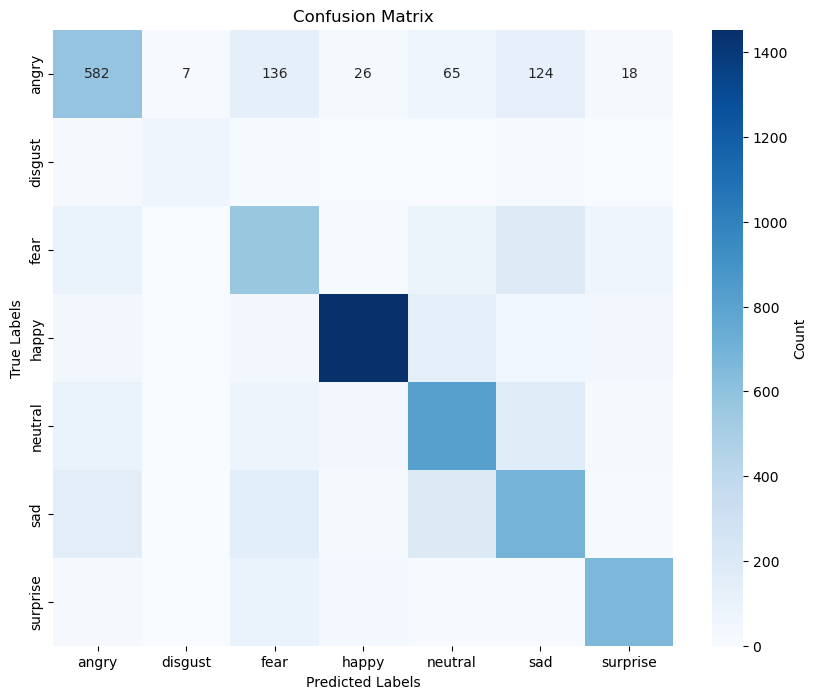

              precision    recall  f1-score   support

       angry       0.56      0.61      0.58       958
     disgust       0.85      0.58      0.69       111
        fear       0.52      0.55      0.53      1024
       happy       0.91      0.82      0.86      1774
     neutral       0.62      0.66      0.64      1233
         sad       0.56      0.55      0.56      1247
    surprise       0.80      0.80      0.80       831

    accuracy                           0.67      7178
   macro avg       0.69      0.65      0.67      7178
weighted avg       0.68      0.67      0.68      7178



In [18]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 10},  # Adjust font size for readability
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [20]:
from sklearn.metrics import f1_score

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"F1-score: {f1}")

F1-score: 0.6763105861312322


In [1]:
import emotion_detection

AttributeError: Can't get attribute 'SwinWithSE' on <module '__main__'>